
# Autoencoder implementation


<div class="alert alert-success">

The dataset consists of data about 1000 customers, encompassing 84 features extracted from their financial transactions and current financial status. The main aim is to utilize this dataset for credit risk assessment and forecasting potential defaults.

Included within are two target variables, one designed for classification and the other for regression analysis:

- **DEFAULT**: Binary target variable indicating if the customer has defaulted (1) or not (0)
- **CREDIT_SCORE**: Numerical target variable representing the customer's credit score (integer)

and these features:

- **INCOME**: Total income in the last 12 months
- **SAVINGS**: Total savings in the last 12 months
- **DEBT**: Total existing debt
- **R_SAVINGS_INCOME**: Ratio of savings to income
- **R_DEBT_INCOME**: Ratio of debt to income
- **R_DEBT_SAVINGS**: Ratio of debt to savings

Transaction groups (**GROCERIES**, **CLOTHING**, **HOUSING**, **EDUCATION**, **HEALTH**, **TRAVEL**, **ENTERTAINMENT**, **GAMBLING**, **UTILITIES**, **TAX**, **FINES**) are categorized.

- **T_{GROUP}_6**: Total expenditure in that group in the last 6 months
- **T_GROUP_12**: Total expenditure in that group in the last 12 months
- **R_[GROUP]**: Ratio of T_[GROUP]6 to T[GROUP]_12
- **R_[GROUP]INCOME**: Ratio of T[GROUP]_12 to INCOME
- **R_[GROUP]SAVINGS**: Ratio of T[GROUP]_12 to SAVINGS
- **R_[GROUP]DEBT**: Ratio of T[GROUP]_12 to DEBT

Categorical Features:

- **CAT_GAMBLING**: Gambling category (none, low, high)
- **CAT_DEBT**: 1 if the customer has debt; 0 otherwise
- **CAT_CREDIT_CARD**: 1 if the customer has a credit card; 0 otherwise
- **CAT_MORTGAGE**: 1 if the customer has a mortgage; 0 otherwise
- **CAT_SAVINGS_ACCOUNT**: 1 if the customer has a savings account; 0 otherwise
- **CAT_DEPENDENTS**: 1 if the customer has any dependents; 0 otherwise
- **CAT_LOCATION**: Location (San Francisco, Philadelphia, Los Angeles, etc.)
- **CAT_MARITAL_STATUS**: Marital status (Married, Widowed, Divorced or Single)
- **CAT_EDUCATION**: Level of Education (Postgraduate, College, High School or Graduate)

</div>


In [1]:
import pandas as pd
from sklearn import set_config

set_config(transform_output="pandas")

<div class="alert alert-info"><b>Loading Data</b>

We load the data in a DataFrame called ```df```.
    
Then, we create the feature matrix ```X``` and the target array ```y``` (```DEFAULT```), then we split them into separate training and test sets with a relative size of 0.75 and 0.25.  
</div>

In [2]:
from sklearn.model_selection import train_test_split

df=pd.read_csv("data.csv")
df.drop(columns=["CUST_ID"],inplace=True)
y=df["DEFAULT"]
X=df.drop(columns=["DEFAULT"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

<div class="alert alert-info"><b>Pipeline for Model</b>

We construct a two-branched `Pipeline` – one branch for categorical attributes and another for numerical attributes. For categorical variables, we employ a `SimpleImputer` with the most frequent strategy and an `OneHotEncoder`. For numerical attributes, we use a `SimpleImputer` with the mean and a `StandardScaler`. The pipeline concludes with the training of an `MLPClassifier`, with the early_stopping criteria set to `True`, and the training restricted to a maximum of 250 iterations.

We will use this model results to test the autoencoder.
</div>

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipe_steps=[('preprocessor', preprocessor), ('classifier', MLPClassifier(max_iter=250, early_stopping=True))]

pipe = Pipeline(steps=pipe_steps)
pipe.fit(X_train, y_train) # Not needed as we do a grid search later

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Unnamed: 0', 'INCOME', 'SAVINGS', 'DEBT', 'R_SAVINGS_INCOME',
       'R_DEBT_INCOME', 'R_DEBT_SAVINGS', 'T_CLOTHING_12', 'T_CLOTHING_6',
       'R_CLOTHING', 'R_CLOTHING_INCOME', 'R_CLOTHING_SAVINGS',
       'R_CLOTHING_DEBT', 'T_ED...
       'CAT_DEPENDENTS', 'CREDIT_SCORE'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['CAT_GAMBLING', 'CAT_LOCATION', 'CAT_MARITAL_STATUS', 'CAT_EDUCATION'], dtype='object'))])),
                ('classifier',
                 MLPClassifier(early_stopping=True, max_iter=250))])

<div class="alert alert-info"><b>Grid Search</b>
    
We try to enhance the predictive capability of the previous neural networkthrough a GridSearchCV.

Finally, we store the score (accuracy) achieved by the best hyperparameter combination in a variable called ```training_score```.
</div>

In [4]:
from sklearn.model_selection import GridSearchCV

params = {
    'classifier__hidden_layer_sizes': [(100,), (50, 50), (25, 25, 25)], # very different structures to be tested
    'classifier__activation': ['relu', 'tanh', 'logistic'], # each activation function aloows for different ranges of output
    'classifier__alpha': [0.0001, 0.001, 0.01] # this is a regularization term that could lead to simpler models
}

grid = GridSearchCV(pipe, param_grid=params, cv=3, scoring='roc_auc')

grid.fit(X_train, y_train)

training_score = grid.best_score_
training_score

0.6025848592685334

<div class="alert alert-info"><b>Generalization Score</b>
    
We compute the generalization score of the previous grid search, to assess whether the model is exhibiting signs of overfitting.
</div>

In [5]:
score = grid.score(X_test, y_test)
print(score, grid.score(X_train, y_train))

0.658338812184966 0.7396096937167351


Similar results which don't show big signs of overfitting.

<div class="alert alert-info"><b>Autoencoder Implementation</b>

We construct a stacked denoising autoencoder using Keras with a scikit-learn wrapper. The objective of the autoencoder is to compress the feature matrix into three dimensions.
</div>

In [6]:
# The method chosen allows to input the autoencoder in a pipeline and do a grid search
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.base import BaseEstimator, TransformerMixin
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

class AutoencoderTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, epochs=100, batch_size=5, verbose=0, structure=[[70, 'relu'], [30, 'relu'], [3, 'sigmoid']], learning_rate=0.001, loss='mse'):
        # Initializing values that will set the hyperparameters later on
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None
        self.encoder = None
        self.structure = structure
        self.learning_rate=learning_rate
        self.optimizer = Adam(learning_rate=self.learning_rate)  # Set learning rate here
        self.loss = loss

    def fit(self, X, y=None):
        #This function creates the internal structure of the encoder, we chose to keep it symmetrical for ease of use
        input_img = Input(shape=(X.shape[1],))
        i=0
        for combination in self.structure:
            if i==0:
                encoded = Dense(combination[0], activation=combination[1])(input_img)
            else:
                encoded = Dense(combination[0], activation=combination[1])(encoded)
            i=1
        
        i=0
        for combination in reversed(self.structure[:-1]):
            if i==0:
                decoded=Dense(combination[0], activation=combination[1])(encoded)
            else:
                decoded=Dense(combination[0], activation=combination[1])(decoded)
            i=1
        
        decoded = Dense(X.shape[1])(decoded)  # Linear output

        
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True) # Set early stopping to reduce the length of training and overfitting
        self.model = Model(input_img, decoded)
        self.model.compile(optimizer=self.optimizer, loss=self.loss)
        self.history = self.model.fit(X, X, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose, validation_split=0.1, callbacks=[early_stopping]) # the validation split allows for early stopping but reduces also the training data

        # this model maps an input to its encoded representation
        self.encoder = Model(input_img, encoded)
        return self

    def transform(self, X, y=None):
        # returns the embeddings
        return self.encoder.predict(X)
    
    def predict(self, X):
        # This function will be used with the scoring of a grid search
        return self.model.predict(X), X # We are returning the prediction and X transformed as it is needed in the scoring method later on

        

<div class="alert alert-info"><b>Creating the Pipeline for the Autoencoder</b>

We construct a pipeline for preparing the feature matrix to be used with the previous autoencoder.
</div>

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class GaussianNoiseTransformer(BaseEstimator, TransformerMixin):
    # Adds noise to the data
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        noise = np.random.normal(self.mean, self.std, X.shape)
        return X + 0.0001*noise

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipe_steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('add_noise', GaussianNoiseTransformer()),
    ('autoencoder', AutoencoderTransformer())
]
pipeline = Pipeline(pipe_steps)

In [9]:
import random

# Optional - we create a function that creates possible combinations of architecture for the autoencoder
def generate_combinations(neurons, activations=['relu', 'softplus', None], n_combinations=10, min_hidden=4):
    # set seed
    random.seed(123)
    # function to create random combination of structures
    neurons=list(set(neurons))
    structure=[]
    for i in range(n_combinations):
        neurons_i=neurons.copy()
        encoding_dim=min(neurons_i) # the encoding dimension will always be the smallest value inputted
        neurons_i.remove(encoding_dim)
        k=random.randint(min_hidden, len(neurons_i))
        
        random_sample = random.sample(neurons_i, k=k) # gettind a random number of hidden layers and random sample of neurons per layer
        
        random_sample.sort(reverse=True)
        structure.append(random_sample)
    
    combinations=[]
    for structure_i in structure:
        combination=[]
        for value in structure_i:
            activation=random.sample(activations, k=1)[0]
            combination.append([value, activation])
        activation=random.sample(activations, k=1)[0]
        combination.append([encoding_dim, activation]) # creating combination of layer and activation function
        combinations.append(combination)

    combinations = [list(map(list, item)) for item in set(tuple(map(tuple, item)) for item in combinations)]  

    return combinations

neurons = [500, 200, 80, 60, 40, 20, 8, 3]
combinations = generate_combinations(neurons, n_combinations=10, min_hidden=2, activations=['softplus', 'elu', None]) # based on trials a more gradual approach ensures a better result
print(combinations)

[[[200, 'elu'], [8, 'softplus'], [3, None]], [[200, None], [80, None], [60, None], [20, None], [8, None], [3, 'elu']], [[500, 'elu'], [200, 'elu'], [80, None], [60, 'elu'], [40, 'softplus'], [20, 'softplus'], [8, None], [3, 'softplus']], [[200, 'elu'], [80, 'softplus'], [60, 'elu'], [40, None], [20, None], [8, None], [3, 'softplus']], [[500, None], [200, 'elu'], [80, 'elu'], [60, None], [40, None], [8, 'softplus'], [3, None]], [[200, None], [8, None], [3, 'elu']], [[500, None], [200, None], [80, 'elu'], [60, 'elu'], [40, None], [8, 'softplus'], [3, None]], [[500, 'softplus'], [200, None], [80, 'softplus'], [40, 'elu'], [20, None], [8, 'elu'], [3, 'softplus']], [[500, 'elu'], [80, 'elu'], [3, None]], [[80, None], [8, 'elu'], [3, 'softplus']]]


In [10]:
param_grid = {
    'autoencoder__epochs': [250], # max epochs
    'autoencoder__structure': combinations,
    'autoencoder__learning_rate':[0.001, 0.01], # testing different learning rates
    'autoencoder__verbose':[1]
}

In [11]:
from sklearn.metrics import make_scorer, mean_squared_error

def autoencoder_loss_scorer(X, prediction):
    return mean_squared_error(prediction[1], prediction[0]) # scoring method chosen for the grid_search comparison


autoencoder_scorer = make_scorer(autoencoder_loss_scorer, greater_is_better=False)


grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring=autoencoder_scorer)
grid_search.fit(X_train, X_train)

Epoch 1/250

90/90 [==============================] - 3s 8ms/step - loss: 0.8944 - val_loss: 0.7248
Epoch 2/250
90/90 [==============================] - 0s 3ms/step - loss: 0.7782 - val_loss: 0.6674
Epoch 3/250
90/90 [==============================] - 0s 3ms/step - loss: 0.7236 - val_loss: 0.6283
Epoch 4/250
90/90 [==============================] - 0s 4ms/step - loss: 0.6824 - val_loss: 0.6090
Epoch 5/250
90/90 [==============================] - 0s 3ms/step - loss: 0.6587 - val_loss: 0.6066
Epoch 6/250
90/90 [==============================] - 0s 3ms/step - loss: 0.6419 - val_loss: 0.5930
Epoch 7/250
90/90 [==============================] - 0s 3ms/step - loss: 0.6332 - val_loss: 0.5892
Epoch 8/250
90/90 [==============================] - 0s 3ms/step - loss: 0.6245 - val_loss: 0.5772
Epoch 9/250
90/90 [==============================] - 0s 3ms/step - loss: 0.6159 - val_loss: 0.5816
Epoch 10/250
90/90 [==============================] - 0s 4ms/step - loss: 0.6086 - val_loss: 0.5818
Epoch 11

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['Unnamed: 0', 'INCOME', 'SAVINGS', 'DEBT', 'R_SAVINGS_INCOME',
       'R_DEBT_INCOME', 'R_DEBT_SAVINGS', 'T_CLOTHING_12', 'T_CLOTHING_6',
       'R_CLOTHING', 'R_CLOTHING_INCOME', 'R_CLOTHING_SAVINGS',
       'R_CLOTHING_DEBT', 'T_ED...
                                                     [3, 'elu']],
                                                    [[500, None], [200, None],
                                                     [80, 'elu'], [60, 'elu'],
                                                     [40, None],
                                                     [8, 'softplus'],
                                                     [3, None]],
                                                    [[500, 'softplus'],
                                                     [200, None],
                                                     [80, 'softplus'],
                                                     [40, 'elu'], [20, None],
                                                     [8, 'elu'],
                                                     [3, 'softplus']],
                                                    [[500, 'elu'], [80, 'elu'],
                                                     [3, None]],
                                                    [[80, None], [8, 'elu'],
                                                     [3, 'softplus']]],
                         'autoencoder__verbose': [1]},
             scoring=make_scorer(autoencoder_loss_scorer, greater_is_better=False))

In [12]:
grid_search.best_params_

{'autoencoder__epochs': 250,
 'autoencoder__learning_rate': 0.001,
 'autoencoder__structure': [[500, 'elu'], [80, 'elu'], [3, None]],
 'autoencoder__verbose': 1}

In [13]:
grid_search.best_score_

-0.6388077049963578

In [14]:
embeddings=grid_search.transform(X_train)
embeddings

24/24 [==============================] - 0s 2ms/step


array([[  4.287951  ,   0.42407632,   1.3517463 ],
       [ -1.4952854 ,  -3.197262  ,   0.98070496],
       [ -3.2481709 ,   5.980605  ,  -1.8597491 ],
       ...,
       [ 15.188078  ,   2.698692  , -12.512763  ],
       [ -2.898413  ,   4.3259397 ,  -2.6536803 ],
       [  0.08941425,  -1.4226025 ,  -0.81629246]], dtype=float32)

<div class="alert alert-info"><b>Quality of the Compression</b>

The following cell comprises the code to visualize the encoded feature matrix, employing the binary target array to color the samples. We also use other plotting methods to analyze the output of the autoencoder.
</div>

In [15]:
import plotly.express as px

embeddings = pd.DataFrame(embeddings, columns=['x', 'y', 'z'])
fig = px.scatter_3d(embeddings, x='x', y='y', z='z', color=y_train)
fig.show()

In [16]:
import plotly.express as px

embeddings_true = pd.DataFrame(embeddings[y_train.reset_index(drop=True)==1], columns=['x', 'y', 'z'])
fig = px.scatter_3d(embeddings_true, x='x', y='y', z='z')
fig.show()

In [17]:
import plotly.express as px

embeddings_false = pd.DataFrame(embeddings[y_train.reset_index(drop=True)==0], columns=['x', 'y', 'z'])
fig = px.scatter_3d(embeddings_false, x='x', y='y', z='z')
fig.show()

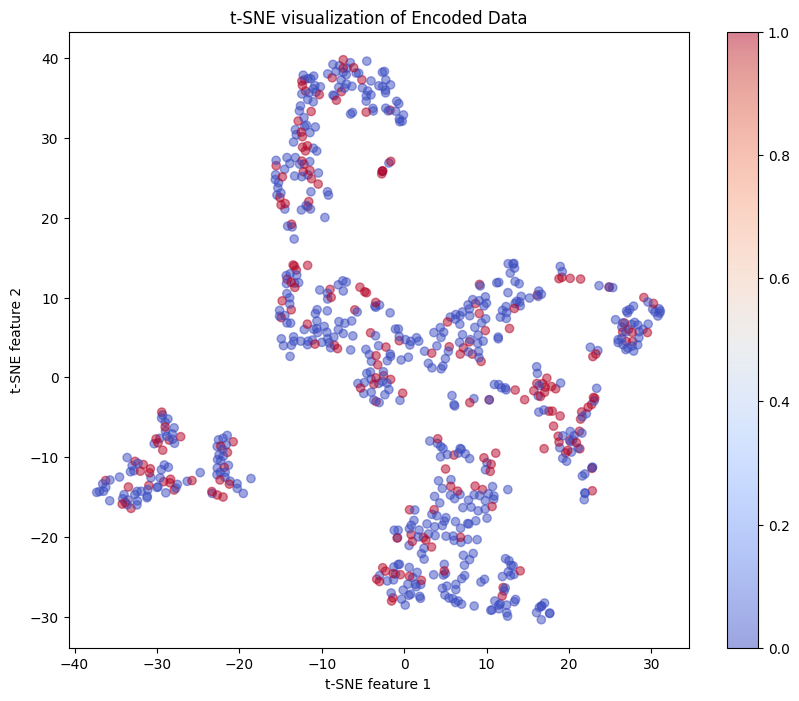

In [18]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(embeddings)

# Plot t-SNE output
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne['tsne0'], X_tsne['tsne1'], c=y_train, cmap='coolwarm', alpha=0.5)
plt.colorbar()
plt.title('t-SNE visualization of Encoded Data')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()


<div class="alert alert-info"><b>Use Case Test</b>

We check whether the autoencoder will be usefull for our use case.
</div>

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

pipe_steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler()), ('classifier', MLPClassifier(max_iter=250, early_stopping=True))]

pipe = Pipeline(steps=pipe_steps)
params = {
    'classifier__hidden_layer_sizes': [(100,), (50, 50), (25, 25, 25)],
    'classifier__activation': ['relu', 'tanh', 'logistic'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate_init': [0.001, 0.01, 0.1]
}

grid = GridSearchCV(pipe, param_grid=params, cv=3, scoring='roc_auc')
grid.fit(embeddings, y_train)
print(grid.best_score_)


0.5813001252774422


### Objective
An autoencoder aims to reduce dimensionality while minimizing information loss.

### Metrics
An MSE of 0.64 suggests the encoding isn't perfect, indicating some loss of information.

### Graphical Analysis
Visualization reveals that the 'true' class is more compact, whereas the 'false' class tends to be more dispersed. This pattern is consistent across multiple runs, showing that the autoencoder captures class-specific distinctions effectively.

### Test Use Case
Applying an MLP Classifier to the encoded data yielded a slight drop in 'roc_auc' validation scores (unbalanced dataset) compared to the unencoded data. However, when the data is encoded into four dimensions, the scores improve, the dimensionality of the encoding might be too strong depending on the use case as it doesn't only get rid of noise but also usefull information.

### Conclusion
The MSE of 0.64, while indicating some information loss, does not significantly hinder the utility of the autoencoder for certain applications. The visualization supports that the encoding retains some class distinctions, proving beneficial for dimensionality reduction. The lower score without the encoding suggest a trade-off between reducing dimensions and maintaining enough information for effective model performance. Ultimately, the autoencoder reduces data complexity efficiently, but the optimal number of retained dimensions requires careful consideration to maximize practical utility for the specific use case.
